#### IMPORTS

In [1]:
import pandas as pd
import numpy as np

import operator

import json
import requests

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

####  GLOBAL VARIABLES

In [2]:
tweet_type = str(input("Enter the type ('n', 'Count_Negatives', 'Count_Positives', 'Count_Neutrals'): "))

Enter the type ('n', 'Count_Negatives', 'Count_Positives', 'Count_Neutrals'): Count_Negatives


In [3]:
title = "Effect_of_{}_tweets_on_Bitcoin_price".format(tweet_type)

#### ACQUISITION

In [4]:
def acquire():
    df = pd.read_csv("Data_To_Hourervals_no_filter.csv", sep =';')
    response = requests.get("https://api.coindesk.com/v1/bpi/historical/close.json?start=2017-01-08&end=2019-01-21")
    results = response.json()
    df2 = pd.DataFrame(results)
    return df, df2

#### WRANGLING

In [5]:
def wrangle(df, df2):
    my_columns = ["Date", "{}".format(tweet_type)]
    for col in df.columns.values:
        if col not in my_columns:
            filtered = df.drop(col, axis = 1)
    
    filtered["Date"] = pd.to_datetime(df["Date"], dayfirst = True)
    filtered["Date"] = filtered["Date"].dt.date
    filtered = filtered.set_index("Date")
    filtered = filtered.groupby("Date").agg({"{}".format(tweet_type): "sum"})
    filtered = filtered.reset_index()
    filtered["Date"] = pd.to_datetime(df["Date"], dayfirst = True)
    
    filtered2 = df2.reset_index()
    filtered2 = filtered2.rename(columns={"index": "Date"})
    filtered2 = filtered2.drop(["disclaimer", "time"], axis = 1)
    filtered2 = filtered2[(filtered2["Date"] != "updatedISO") & (filtered2["Date"] != "updated")]
    filtered2["Date"] = pd.to_datetime(filtered2["Date"], dayfirst = True)
    
    return filtered, filtered2

#### ANALYSIS

In [6]:
def analyze(filtered, filtered2):
    Count_labels = ["Few", "Medium", "Many"]
    bins = pd.qcut(filtered["{}".format(tweet_type)], 3, labels = Count_labels)
    filtered["{}".format(tweet_type)] = bins
    
    for i in filtered["Date"]:
        for e in filtered2["Date"]:
            if i == e:
                filtered["BPI"] = filtered2["bpi"]
                
    BPIs = []
    for i in range(len(filtered["BPI"]) - 1):
        BPIs.append((filtered["BPI"][i+1] - filtered["BPI"][i])/filtered["BPI"][i])
    BPIs.append(0)
    filtered["Price_Change"] = BPIs
    
    filtered = filtered.drop(["BPI", "Date"], axis =1)
    
    filtered = filtered.groupby("{}".format(tweet_type)).agg({"Price_Change": "mean"})
    
    results = filtered.reset_index()
    return results

#### REPORTING

In [7]:
def visualize(results):
    fig, ax = plt.subplots(figsize = (9,8))
    barchart = sns.barplot(data = results, x = "{}".format(tweet_type), y = "Price_Change")
    plt.title(title + "\n", fontsize = 20)
    return barchart

def save_viz(barchart):
    fig = barchart.get_figure()
    fig.savefig(title + '.png')

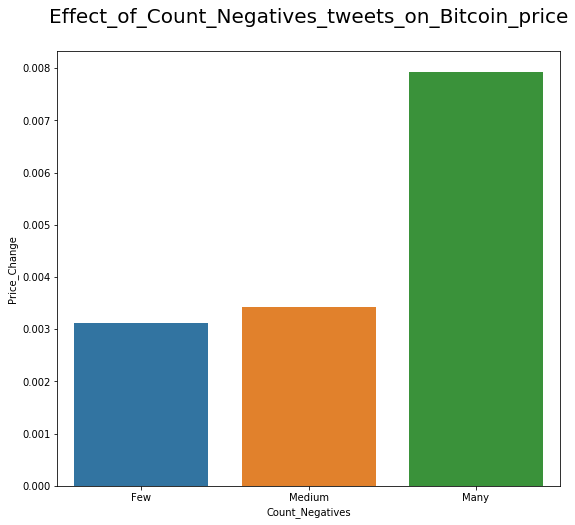

In [8]:
if __name__ == '__main__':
    df, df2 = acquire()
    filtered, filtered2 = wrangle(df, df2)
    results = analyze(filtered, filtered2)
    barchart = visualize(results)
    save_viz(barchart)